In [1]:
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from tqdm import tqdm
import torch


class ImdbDataset(Dataset):
    def __init__(self, is_train=True):
        # label genre
        with open('dataset/genres.txt', 'r') as f:
            genre_all = f.readlines()
            genre_all = [x.replace('\n','') for x in genre_all]
        self.genre2idx = {genre:idx for idx, genre in enumerate(genre_all)}

    def __getitem__(self, index):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        genre = self.data.iloc[index].genre

        # preprocess text
        if len(self.data) > 1000:
            self.summary = np.load('dataset/mistral_rating_db/summary_embeddings_train.npy')
        else:
            self.summary = np.load('dataset/mistral_rating_db/summary_embeddings_test.npy')

        title_tensor = torch.from_numpy(self.summary[index]).float()
        title_tensor.to(self.device)

        # preprocess image
        img_vec = self.img_vector[index]
        img_tensor = torch.from_numpy(img_vec).float()
        img_tensor.to(self.device)        

        # preprocess label
        genre_vector = np.zeros(len(self.genre2idx))

        for g in genre:
            genre_vector[self.genre2idx[g]] = 1
        genre_tensor = torch.from_numpy(genre_vector).float()
        genre_tensor.to(self.device)

        return title_tensor, img_tensor, genre_tensor

    def __len__(self):
        return len(self.data)

In [2]:
train_data = torch.load('dataset/train_set_vgg19_hf.pt')
test_data = torch.load('dataset/test_set_vgg19_hf.pt')

In [3]:
BATCH_SIZE = 32
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

for title, img, genre in train_loader:
    print(title.shape, img.shape, genre.shape)
    break
for title, img, genre in test_loader:
    print(title.shape, img.shape, genre.shape)
    break

torch.Size([32, 10]) torch.Size([32, 1000]) torch.Size([32, 18])
torch.Size([32, 10]) torch.Size([32, 1000]) torch.Size([32, 18])


In [8]:
from torch import nn

class ImdbModel_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(1010, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 18),
        )
        self.norm_img = nn.BatchNorm1d(1000)
        self.norm_title = nn.BatchNorm1d(10)


    def forward(self, title, img):
        # normalize
        title = self.norm_title(title)
        img = self.norm_img(img)

        x = torch.cat([title, img], dim=1)
        x = self.fc(x)
        return x
    
model = ImdbModel_2()
model

ImdbModel_2(
  (fc): Sequential(
    (0): Linear(in_features=1010, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=18, bias=True)
  )
  (norm_img): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm_title): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [15]:
from tqdm import tqdm
from torchmetrics.classification import MultilabelF1Score

num_labels = genre.shape[1]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

history = {'train_loss': [], 'test_loss': []}
f1_score = {'train': [], 'test': []}

f1 = MultilabelF1Score(num_labels=num_labels, threshold=0.5, average='macro')
f1 = f1.to(device)
 
def test(model):
    model.eval()
    test_loss = 0
    f1_all = 0

    with torch.no_grad():
        for title, img, genre in test_loader:
            title, img, genre = title.to(device), img.to(device), genre.to(device)
            outputs = model(title, img)
            loss = criterion(outputs, genre)
            test_loss += loss.item()
            
            f1_all += f1(outputs, genre)

    test_loss /= len(test_loader)
    f1_all /= len(test_loader)

    return test_loss, f1_all

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    for idx, (title, img, genre) in enumerate(tqdm(train_loader)):
        title, img, genre = title.to(device), img.to(device), genre.to(device)
        optimizer.zero_grad()
        outputs = model(title, img)
        loss = criterion(outputs, genre)
        loss.backward()
        optimizer.step()

    train_loss = loss.item()
    test_loss, f1_all = test(model)

    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, train_loss: {train_loss:.4f}, test_loss: {test_loss:.4f}, f1: {f1_all:.4f}')

100%|██████████| 98/98 [00:06<00:00, 14.51it/s]


Epoch 1/20, train_loss: 2.8828, test_loss: 9.5152, f1: 0.2573


100%|██████████| 98/98 [00:08<00:00, 12.01it/s]


Epoch 2/20, train_loss: 1.2800, test_loss: 8.2144, f1: 0.2638


100%|██████████| 98/98 [00:08<00:00, 11.84it/s]


Epoch 3/20, train_loss: 1.9399, test_loss: 8.3488, f1: 0.2565


100%|██████████| 98/98 [00:08<00:00, 11.84it/s]


Epoch 4/20, train_loss: 3.8458, test_loss: 8.7734, f1: 0.2554


100%|██████████| 98/98 [00:05<00:00, 18.09it/s]


Epoch 5/20, train_loss: 11.6218, test_loss: 8.3609, f1: 0.2582


100%|██████████| 98/98 [00:05<00:00, 17.08it/s]


Epoch 6/20, train_loss: 7.5131, test_loss: 9.0004, f1: 0.2514


100%|██████████| 98/98 [00:05<00:00, 19.10it/s]


Epoch 7/20, train_loss: 2.2506, test_loss: 8.3998, f1: 0.2391


100%|██████████| 98/98 [00:05<00:00, 19.01it/s]


Epoch 8/20, train_loss: 3.5263, test_loss: 8.9484, f1: 0.2542


100%|██████████| 98/98 [00:05<00:00, 19.25it/s]


Epoch 9/20, train_loss: 5.4473, test_loss: 9.5748, f1: 0.2575


100%|██████████| 98/98 [00:04<00:00, 24.36it/s]


Epoch 10/20, train_loss: 7.0602, test_loss: 10.0675, f1: 0.2501


100%|██████████| 98/98 [00:05<00:00, 19.56it/s]


Epoch 11/20, train_loss: 2.4719, test_loss: 9.1390, f1: 0.2605


100%|██████████| 98/98 [00:04<00:00, 24.48it/s]


Epoch 12/20, train_loss: 7.2918, test_loss: 10.0469, f1: 0.2428


100%|██████████| 98/98 [00:05<00:00, 19.19it/s]


Epoch 13/20, train_loss: 1.4768, test_loss: 9.0573, f1: 0.2458


100%|██████████| 98/98 [00:05<00:00, 18.81it/s]


Epoch 14/20, train_loss: 2.2020, test_loss: 7.5589, f1: 0.2529


100%|██████████| 98/98 [00:04<00:00, 24.11it/s]


Epoch 15/20, train_loss: 2.1358, test_loss: 9.1306, f1: 0.2501


100%|██████████| 98/98 [00:05<00:00, 19.01it/s]


Epoch 16/20, train_loss: 2.0141, test_loss: 9.6715, f1: 0.2604


100%|██████████| 98/98 [00:05<00:00, 19.38it/s]


Epoch 17/20, train_loss: 1.6751, test_loss: 8.5298, f1: 0.2552


100%|██████████| 98/98 [00:04<00:00, 23.96it/s]


Epoch 18/20, train_loss: 1.5288, test_loss: 7.9695, f1: 0.2436


100%|██████████| 98/98 [00:04<00:00, 19.74it/s]


Epoch 19/20, train_loss: 1.8562, test_loss: 8.5627, f1: 0.2593


100%|██████████| 98/98 [00:05<00:00, 18.93it/s]


Epoch 20/20, train_loss: 0.6123, test_loss: 8.3355, f1: 0.2532


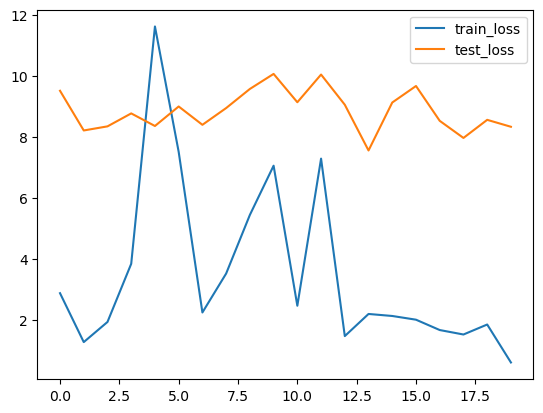

In [16]:
from matplotlib import pyplot as plt
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['test_loss'], label='test_loss')
plt.legend()
plt.show()